# Tutorial: browsing wells and summary data across SA

python-sa-gwdata has a statewide cache of what we call "summary" data available for you to browse and query.

We will download the relevant data using this package (python-sa-gwdata) -- importable as ``sa_gwdata`` -- and use some other packages for other things:

- matplotlib, numpy, pandas - used in the background

In [6]:
import sa_gwdata

import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as cx

You might get a warning message like this:

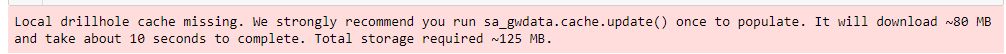

If so, you should run this line of code - it will download the summary statewide layer of summary data:

In [7]:
sa_gwdata.cache.update()

The data cache will then sit there until you run the update method (same code as above) again to re-download it. About 200 new wells are created each month, so it may or may not be important to you to update it frequently.

(This next step is optional: You can specify the working coordinate reference system (CRS). I'm going to use [SA Lambert GDA2020](https://epsg.io/8059), which is in eastings and northings and covers the whole state. You can pick any!

In [8]:
session = sa_gwdata.get_global_session(working_crs="EPSG:8059")

This variable (``session``), you can either use, or ignore. If you use the module-level functions as shown below, the package will use ``session`` in the background.)

## Intro to the summary layer

This dataframe covers all wells/drillholes in South Australia:

In [9]:
df = sa_gwdata.summary_layer()
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 361745 entries, 0 to 361744
Data columns (total 82 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   UNIT_NO               361745 non-null  int64         
 1   DHNO                  361745 non-null  int64         
 2   NAME                  361745 non-null  object        
 3   EASTING               361745 non-null  float64       
 4   NORTHING              361745 non-null  float64       
 5   ZONE                  361745 non-null  int64         
 6   LAT                   361745 non-null  float64       
 7   LON                   361745 non-null  float64       
 8   REF_ELEV              37821 non-null   float64       
 9   GRND_ELEV             268204 non-null  float64       
 10  HUND                  361745 non-null  object        
 11  PARCEL                361745 non-null  category      
 12  PARCELNO              361745 non-null  object     

There are 80 columns with varying degrees of reliability or usefulness. The documentation will cover all of them, eventually, but for now let's focus on a couple. 

## Drilled date

When were most wells drilled?

<Axes: xlabel='DRILL_DATE'>

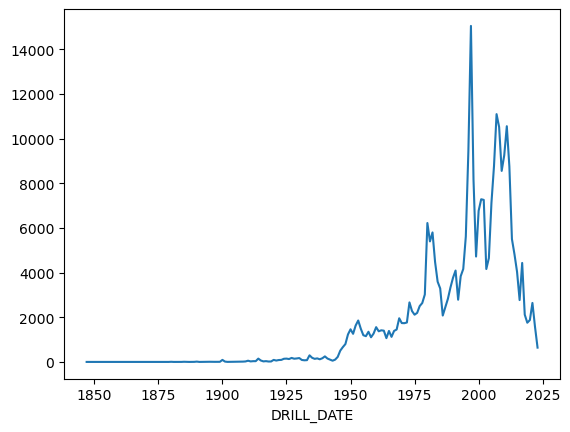

In [24]:
df.groupby(df.DRILL_DATE.dt.year).DHNO.count().plot()

## Log availability

Whereabouts are wells with logs located?

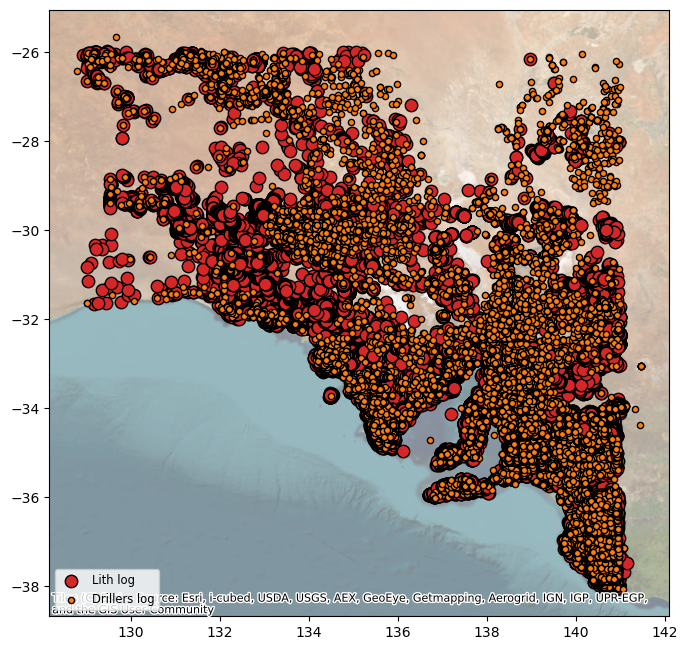

In [29]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
df[df.LOGGEOL == 'Y'].geometry.plot(fc='tab:red', ec='k', marker='o', markersize=80, ax=ax, label='Lith log')
df[df.LOGDRILL == 'Y'].geometry.plot(fc='tab:orange', ec='k', marker='o', markersize=20, ax=ax, label='Drillers log')
cx.add_basemap(ax, source=cx.providers.Esri.WorldImagery, crs=session.working_crs, alpha=0.5)
ax.legend(fontsize='small')

And the below figure compares hydrostrat logs (water-focused) with strat logs (generally more mineral exploration-focused):

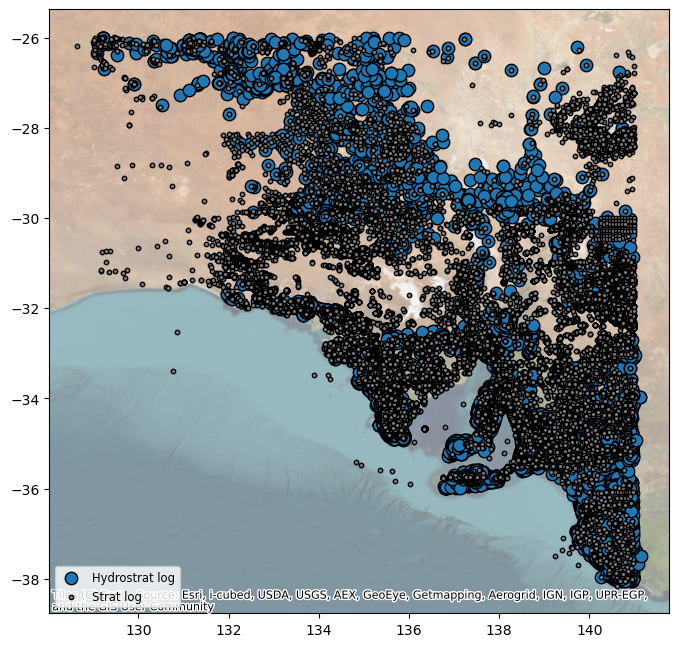

In [31]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
df[df.LOGHYDROSTRAT == 'Y'].geometry.plot(fc='tab:blue', ec='k', marker='o', markersize=80, ax=ax, label='Hydrostrat log')
df[df.LOGSTRAT == 'Y'].geometry.plot(fc='tab:grey', ec='k', marker='o', markersize=10, ax=ax, label='Strat log')
cx.add_basemap(ax, source=cx.providers.Esri.WorldImagery, crs=session.working_crs, alpha=0.5)
ax.legend(fontsize='small')

## Aquifer monitored codes

These codes show the aquifer which a well is completed in:

In [36]:
df.groupby(['AQ_MON']).DHNO.count().sort_values(ascending=False).head(20)

AQ_MON
            235758
Thg          20156
Qpm          19168
Qpah         10795
Qpcb          9978
Ty            5025
Nds           4037
Ty(conf)      3560
Qhcks         2797
Ndw           2355
Nnt           1876
Qhck          1733
Tomw(T2)      1636
Ndt           1595
CP-j          1590
Eeb           1557
Qam           1550
Q             1448
Tomw(T1)      1372
Qa            1296
Name: DHNO, dtype: int64

As you can see the majority (235,000) have no aquifer code assigned, since it's not automatic. The majority of wells with codes are those in the South East (Thg is Gambier Limestone).

More info to come on how to find out more about what those codes mean.

## Salinity data - most recent value

The columns TDS and EC have the most recent salinity value, with TDSDATE showing the date:

In [11]:
sal_df = df[~pd.isnull(df.EC)]
len(sal_df)

116645

So about a third of all wells have at least one salinity measurement:

In [20]:
len(sal_df[sal_df.TDSDATE.dt.year >= 2013])

12177

And of the wells with salinity observations, only about 10% were measured in the last decade.

Show a crude visualisation of the variation in salinity:

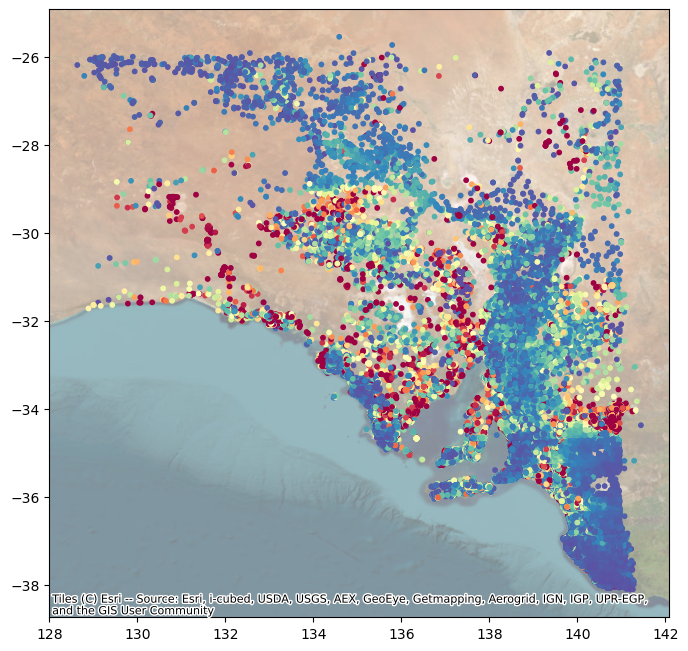

In [49]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
sal_df.plot(kind='geo', column='TDS', vmin=100, vmax=30000, markersize=10, ax=ax, cmap='Spectral_r')
cx.add_basemap(ax, source=cx.providers.Esri.WorldImagery, crs=session.working_crs, alpha=0.5)